In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

Introduction:
In this first block of code, we create dictionaries mapping team ids to teams, teams to their games and teams to their seasons. This data format will allow for easy retrieval when we perform data analysis later

In [3]:
import csv

id_to_team = {}
with open('teams.csv', newline='') as csvfile1:
    team_info_reader = csv.reader(csvfile1, delimiter=',')
    for row in team_info_reader:
        if row[1] == 'TEAM_ID':
            continue
            
        id_to_team[row[1]] = '{}{}'.format(row[7], row[5])
        
#print(id_to_team)

team_to_games = {}
team_list_game = []
with open('games.csv', newline='') as csvfile2:
    game_reader = csv.reader(csvfile2, delimiter=',')
    for row in game_reader:
        if row[3] == 'HOME_TEAM_ID':
            continue
        team_name_home = id_to_team[row[3]]
        team_name_away = id_to_team[row[4]]
        if team_name_home in team_list_game:
            team_to_games[team_name_home].append(row)
        else:
            team_to_games[team_name_home] = [row]
            team_list_game.append(team_name_home)
        if team_name_away in team_list_game:
            team_to_games[team_name_away].append(row)
        else:
            team_to_games[team_name_away] = [row]
            team_list_game.append(team_name_away)
        
firstpair = {k: team_to_games[k] for k in list(team_to_games)[:1]}
# print(firstpair)


team_to_years = {}
team_list = []
with open('Team_Records.csv', newline='') as csvfile3:
    team_reader = csv.reader(csvfile3, delimiter=',')
    for row in team_reader:
        team_name = ''.join(char for char in row[2] if char.isalnum())
        if team_name == 'Team':
            continue
        if team_name in team_list:
            team_to_years[team_name].append(row)
        else:
            team_to_years[team_name] = [row]
            team_list.append(team_name)
            
# print(team_to_years)

In [7]:
## can make master list of all years if we want
## games_scores is a dictionary mapping team names to all of their recorded games
## each value is a list of [season, game_date, score_difference, win?(0 or 1), blowout_win?, close_win?, blowout_loss?, close_loss?]
games_scores = {}
for key in team_to_games:
    cur_team_games = team_to_games[key]
    new_team_games = []
    for g in cur_team_games:
        home_score = 0
        away_score = 0
        try:
            home_score = int(g[7])
        except:
            try:
                home_score = int(g[7][:-2])
            except:

                continue
        try:
            away_score = int(g[14])
        except:
            try:
                away_score = int(g[14][:-2])
            except:
                continue
        ## home team
        if id_to_team[g[3]] == key:
            diff = home_score - away_score
            blowout_win = '0'
            if diff >= 20:
                blowout_win = '1'
            close_win = '0'
            if diff <= 5 and diff > 0:
                close_win = '1'
            blowout_loss = '0'
            if diff <= -20:
                blowout_loss = '1'
            close_loss = '0'
            if diff >= -5 and diff < 0:
                close_loss = '1'
                
            new_team_games.append([g[5], g[0], str(diff), g[20], blowout_win, close_win, blowout_loss, close_loss])
        ## away team
        else:
            win = '1'
            if g[20] == '1':
                win = '0'
            new_team_games.append([g[5], g[0], str(diff), win, blowout_win, close_win, blowout_loss, close_loss])
    new_games_sorted = sorted(new_team_games, key=lambda x: x[0])
    games_scores[key] = new_games_sorted
    
# print(games_scores)

In [5]:
#print(team_to_years['MinnesotaTimberwolves'])
## can make master list of all teams records if we want
## year_stats is a dictionary mapping team names to all of their recorded seasons
## each value is a list of [season, #wins, #losses, win_percentage, playoffs, SRS]
## SRS represents points above average per game in a season (performance metric, 0 is baseline)
year_stats = {}
for key in team_to_years:
    cur_team_stats = []
    for year in team_to_years[key]:
        cur_year = [year[0], year[3], year[4], year[5], year[14], year[7]]
        cur_team_stats.append(cur_year)
    new_years_sorted = sorted(cur_team_stats, key=lambda x: x[0])
    year_stats[key] = new_years_sorted

#print(year_stats)

In [8]:
## sample code to get a range of games by date and season
timberwolves_games = games_scores['MinnesotaTimberwolves']
for game in timberwolves_games:
    if game[0] == '2018' and game[1] >= '2018-10-17' and game[1] <= '2018-12-28':
        # print(game)
        pass

In [21]:
## winning and losing streaks for all teams

games_streaks = {}
for key in games_scores:
    win_streaks = []
    loss_streaks = []
    all_streaks = []
    win_count = 0
    cur_year = games_scores[key][0][0]
    loss_count = 0
    prev_game = games_scores[key][0]
    if prev_game[3] == 1:
        win_count += 1
    else:
        loss_count += 1
    for g in games_scores[key]:
        if g == games_scores[key][0]:
            continue
        if prev_game[3] == '1' and g[3] == '1' and g[0] == cur_year and prev_game[0] == cur_year:
            win_count += 1
        elif prev_game[3] == '0' and g[3] == '0' and g[0] == cur_year and prev_game[0] == cur_year:
            loss_count += 1
        elif prev_game[3] == '1' and g[3] == '0' and g[0] == cur_year and prev_game[0] == cur_year:
            win_streaks.append(win_count)
            all_streaks.append(win_count)
            win_count = 0
            loss_count += 1
        elif prev_game[3] == '0' and g[3] == '1' and g[0] == cur_year and prev_game[0] == cur_year:
            loss_streaks.append(loss_count)
            all_streaks.append(0 - loss_count)
            loss_count = 0
            win_count += 1
        elif g[0] != cur_year:
            cur_year = g[0]
            if win_count > 0:
                win_streaks.append(win_count)
                all_streaks.append(win_count)
                win_count = 0
            else:
                loss_streaks.append(loss_count)
                all_streaks.append(0 - loss_count)
                loss_count = 0
            if g[3] == '1':
                win_count += 1
            else:
                loss_count += 1
        elif prev_game[0] != cur_year:
            print("hello")
            if g[3] == '1':
                win_count += 1
            else:
                loss_count += 1
        else:
            pass
        prev_game = g
    games_streaks[key] = all_streaks
    
# print(win_streaks)
#print(loss_streaks)
# print(all_streaks)
#print(games_streaks)

## cases
#start of win streak - end of loss streak
#middle of win streak
#end of win streak - end of loss streak (either next game loss or new year)
#middle of loss streak        

<ipython-input-66-c70c5e0f13c7>:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


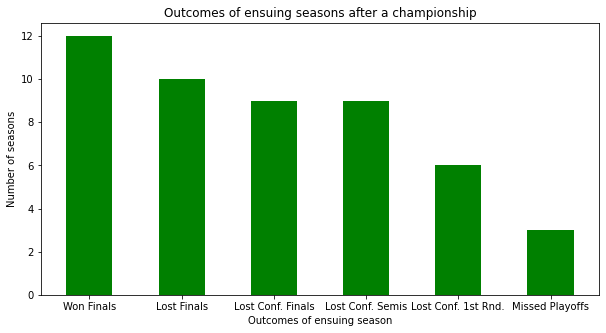

In [66]:
## Question 1: Defending champions performance in ensuing year
next_seasons = []
for key in year_stats:
    b = False
    for year in year_stats[key]:
        if int(year[0][:4]) < 1970:
            continue
        if b == True:
            next_seasons.append(year)
            b = False
        if year[4] == 'Won Finals':
            b = True

next_seasons_sorted = sorted(next_seasons, key=lambda x: x[0])

next_seasons_performances = {}
temp = []
for item in next_seasons_sorted:
    performance = item[4]
    if performance == '':
        performance = 'Missed Playoffs'
    if performance == 'Lost W. Div. Finals' or performance == 'Lost E. Div. Finals':
        continue
    if performance == 'Lost E. Div. Semis':
        continue
    if performance == 'Lost E. Conf. Finals' or performance == 'Lost W. Conf. Finals':
        performance = 'Lost Conf. Finals'
    if performance == 'Lost E. Conf. Semis' or performance == 'Lost W. Conf. Semis':
        performance = 'Lost Conf. Semis'
    if performance == 'Lost E. Conf. 1st Rnd.' or performance == 'Lost W. Conf. 1st Rnd.':
        performance = 'Lost Conf. 1st Rnd.'
    if performance in temp:
        next_seasons_performances[performance] += 1
    else:
        temp.append(performance)
        next_seasons_performances[performance] = 1


next_seasons_performances = {k: v for k, v in sorted(next_seasons_performances.items(), key=lambda item: item[1], reverse=True)}


fig, ax = plt.subplots(figsize=(10,5))
bar = plt.bar(next_seasons_performances.keys(), next_seasons_performances.values(), width=0.5, color='g')
ax.set_xlabel('Outcomes of ensuing season')
ax.set_ylabel('Number of seasons')
ax.set_title('Outcomes of ensuing seasons after a championship')
fig.show()

27 0.0
26 1.0
25 0.5
24 1.0
23 1.0
22 0.6666666666666666
21 1.0
20 0.75
19 0.5714285714285714
18 0.875
17 0.5714285714285714
16 0.8235294117647058
15 0.85
14 0.7407407407407407
13 0.6585365853658537
12 0.7321428571428571
11 0.6511627906976745
10 0.7543859649122807
9 0.7169811320754716
8 0.7035398230088495
7 0.6295264623955432
6 0.6232638888888888
5 0.5742771684945165
4 0.5734705546026301
3 0.5721295387634936
2 0.5302688638334779
1 0.49852992044275335
0 1.0
-1 0.5052523699718166
-2 0.4873122734334542
-3 0.432996632996633
-4 0.42814726840855105
-5 0.37279335410176534
-6 0.40728476821192056
-7 0.32122905027932963
-8 0.35802469135802467
-9 0.27564102564102566
-10 0.35398230088495575
-11 0.2328767123287671
-12 0.17857142857142858
-13 0.3695652173913043
-14 0.1724137931034483
-15 0.25
-16 0.2777777777777778
-17 0.07692307692307693
-18 0.3333333333333333
-19 0.375
-20 0.0
-21 0.0
-22 0.4
-23 0.3333333333333333
-24 0.0
-25 0.0
-26 1.0


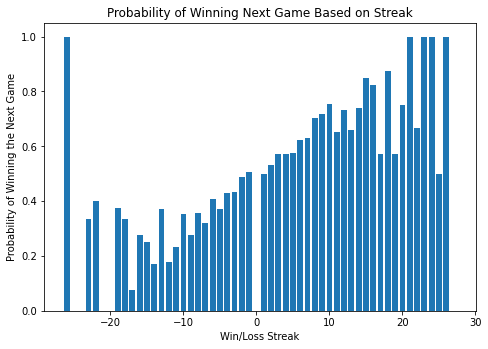

In [35]:
## Question 2: Probability of winning next game based on current streak

streaks_records = {}
streaks = []
for key in games_streaks:
    for s in games_streaks[key]:
        if s > 0:
            if s in streaks:
                streaks_records[s][1] += 1
            else:
                streaks.append(s)
                streaks_records[s] = [0,1]
            for i in range(1,s):
                if i in streaks:
                    streaks_records[i][0] += 1
                else:
                    streaks.append(i)
                    streaks_records[i] = [1,0]
        else:
            if s in streaks:
                streaks_records[s][0] += 1
            else:
                streaks.append(s)
                streaks_records[s] = [1,0]
            for i in range(1,-s):
                i = i * -1
                if i in streaks:
                    streaks_records[i][1] += 1
                else:
                    streaks.append(i)
                    streaks_records[i] = [0,1]

streaks_records = {k: v for k, v in sorted(streaks_records.items(), key=lambda item: item[0], reverse=True)}
for key in streaks_records:
    # print(key, streaks_records[key])
    pass

streaks_odds = {}
for key in streaks_records:
    streaks_odds[key] = float(streaks_records[key][0]) / (streaks_records[key][1] + streaks_records[key][0])
    
keys = []
prob = []
for key in streaks_odds:
    # print(key, streaks_odds[key])
    keys.append(key)
    prob.append(streaks_odds[key])
del keys[27]
del prob[27]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(keys,prob)
ax.set_xlabel('Win/Loss Streak')
ax.set_ylabel('Probability of Winning the Next Game')
ax.set_title('Probability of Winning Next Game Based on Streak')
plt.show()

In [36]:
## Questions 3-6 prep
data36 = [[0,0],[0,0],[0,0],[0,0]] ## blowout win, close win, blowout loss, close loss

for key in games_scores:
    b0 = False
    b1 = False
    b2 = False
    b3 = False
    for game in games_scores[key]:
        if b0:
            if game[3] == '1':
                data36[0][0] += 1
            else:
                data36[0][1] += 1
            b0 = False
        if b1:
            if game[3] == '1':
                data36[1][0] += 1
            else:
                data36[1][1] += 1
            b1 = False
        if b2:
            if game[3] == '1':
                data36[2][0] += 1
            else:
                data36[2][1] += 1
            b2 = False
        if b3:
            if game[3] == '1':
                data36[3][0] += 1
            else:
                data36[3][1] += 1
            b3 = False
            
        ## blowout win
        if game[4] == '1':
            b0 = True
        ## close win
        elif game[5] == '1':
            b1 = True
        ## blowout loss
        elif game[6] == '1':
            b2 = True
        ## close loss
        elif game[7] == '1':
            b3 = True 
        else:
            pass

print(data36)

[[2854, 2129], [3779, 3601], [994, 1418], [3062, 3385]]


In [37]:
## Question 3
num_wins0 = data36[0][0]
num_loss0 = data36[0][1]
pct0 = float(num_wins0) / (num_loss0 + num_wins0)
print("Afte a blowout win, teams have " + str(num_wins0) + " wins and " + str(num_loss0) + " losses with a winning percentage of " + str(pct0))

Afte a blowout win, teams have 2854 wins and 2129 losses with a winning percentage of 0.5727473409592615


In [38]:
## Question 4
num_wins1 = data36[1][0]
num_loss1 = data36[1][1]
pct1 = float(num_wins1) / (num_loss1 + num_wins1)
print("Afte a close win, teams have " + str(num_wins1) + " wins and " + str(num_loss1) + " losses with a winning percentage of " + str(pct1))

Afte a close win, teams have 3779 wins and 3601 losses with a winning percentage of 0.5120596205962059


In [39]:
## Question 5
num_wins2 = data36[2][0]
num_loss2 = data36[2][1]
pct2 = float(num_wins2) / (num_loss2 + num_wins2)
print("Afte a blowout loss, teams have " + str(num_wins2) + " wins and " + str(num_loss2) + " losses with a winning percentage of " + str(pct2))

Afte a blowout loss, teams have 994 wins and 1418 losses with a winning percentage of 0.412106135986733


In [40]:
## Question 6
num_wins3 = data36[3][0]
num_loss3 = data36[3][1]
pct3 = float(num_wins0) / (num_loss3 + num_loss3)
print("Afte a close loss, teams have " + str(num_wins3) + " wins and " + str(num_loss3) + " losses with a winning percentage of " + str(pct3))

Afte a close loss, teams have 3062 wins and 3385 losses with a winning percentage of 0.42156573116691287


/var/folders/yh/0wx5sr8520bcl4c1grkslxww0000gn/T/ipykernel_29487/3053723686.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


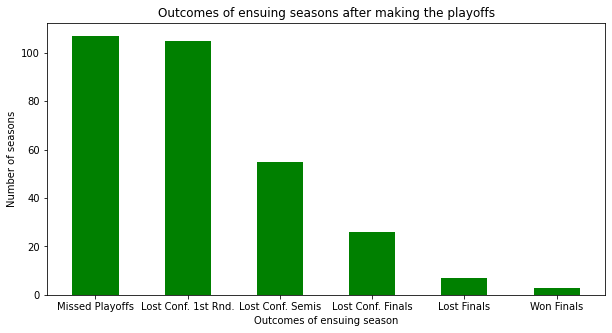

In [41]:
## Question 7: Making playoffs performance in ensuing year
next_seasons = []
for key in year_stats:
    b = False
    for year in year_stats[key]:
        if int(year[0][:4]) < 1970:
            continue
        if b == True:
            next_seasons.append(year)
            b = False
        if '1st Rnd.' in year[4]:
            b = True

next_seasons_sorted = sorted(next_seasons, key=lambda x: x[0])

next_seasons_performances = {}
temp = []
for item in next_seasons_sorted:
    performance = item[4]
    if performance == '':
        performance = 'Missed Playoffs'
    if performance == 'Lost W. Div. Finals' or performance == 'Lost E. Div. Finals':
        continue
    if performance == 'Lost E. Div. Semis':
        continue
    if performance == 'Lost E. Conf. Finals' or performance == 'Lost W. Conf. Finals':
        performance = 'Lost Conf. Finals'
    if performance == 'Lost E. Conf. Semis' or performance == 'Lost W. Conf. Semis':
        performance = 'Lost Conf. Semis'
    if performance == 'Lost E. Conf. 1st Rnd.' or performance == 'Lost W. Conf. 1st Rnd.':
        performance = 'Lost Conf. 1st Rnd.'
    if performance in temp:
        next_seasons_performances[performance] += 1
    else:
        temp.append(performance)
        next_seasons_performances[performance] = 1


next_seasons_performances = {k: v for k, v in sorted(next_seasons_performances.items(), key=lambda item: item[1], reverse=True)}


fig, ax = plt.subplots(figsize=(10,5))
bar = plt.bar(next_seasons_performances.keys(), next_seasons_performances.values(), width=0.5, color='g')
ax.set_xlabel('Outcomes of ensuing season')
ax.set_ylabel('Number of seasons')
ax.set_title('Outcomes of ensuing seasons after making the playoffs')
fig.show()

/var/folders/yh/0wx5sr8520bcl4c1grkslxww0000gn/T/ipykernel_29487/508278567.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


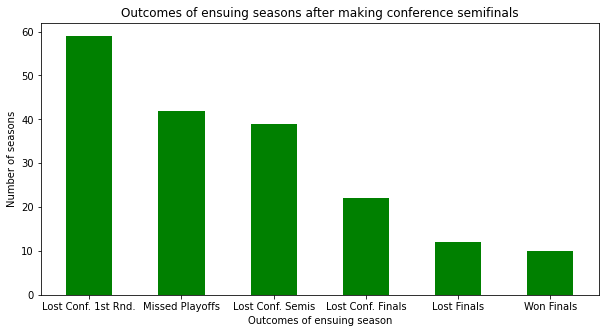

In [42]:
## Question 8: Making conference semifinals performance in ensuing year
next_seasons = []
for key in year_stats:
    b = False
    for year in year_stats[key]:
        if int(year[0][:4]) < 1970:
            continue
        if b == True:
            next_seasons.append(year)
            b = False
        if 'Conf. Semis' in year[4]:
            b = True

next_seasons_sorted = sorted(next_seasons, key=lambda x: x[0])

next_seasons_performances = {}
temp = []
for item in next_seasons_sorted:
    performance = item[4]
    if performance == '':
        performance = 'Missed Playoffs'
    if performance == 'Lost W. Div. Finals' or performance == 'Lost E. Div. Finals':
        continue
    if performance == 'Lost E. Div. Semis':
        continue
    if performance == 'Lost E. Conf. Finals' or performance == 'Lost W. Conf. Finals':
        performance = 'Lost Conf. Finals'
    if performance == 'Lost E. Conf. Semis' or performance == 'Lost W. Conf. Semis':
        performance = 'Lost Conf. Semis'
    if performance == 'Lost E. Conf. 1st Rnd.' or performance == 'Lost W. Conf. 1st Rnd.':
        performance = 'Lost Conf. 1st Rnd.'
    if performance in temp:
        next_seasons_performances[performance] += 1
    else:
        temp.append(performance)
        next_seasons_performances[performance] = 1


next_seasons_performances = {k: v for k, v in sorted(next_seasons_performances.items(), key=lambda item: item[1], reverse=True)}


fig, ax = plt.subplots(figsize=(10,5))
bar = plt.bar(next_seasons_performances.keys(), next_seasons_performances.values(), width=0.5, color='g')
ax.set_xlabel('Outcomes of ensuing season')
ax.set_ylabel('Number of seasons')
ax.set_title('Outcomes of ensuing seasons after making conference semifinals')
fig.show()

/var/folders/yh/0wx5sr8520bcl4c1grkslxww0000gn/T/ipykernel_29487/2712900897.py:47: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


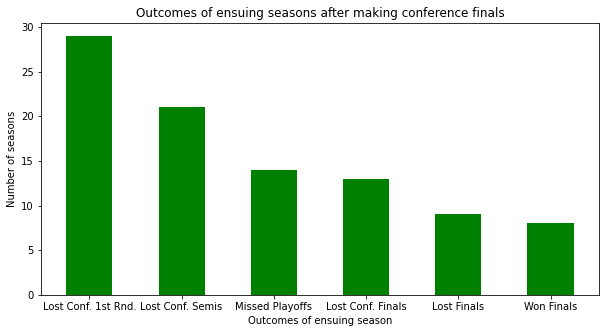

In [43]:
## Question 9: Making conference finals performance in ensuing year
next_seasons = []
for key in year_stats:
    b = False
    for year in year_stats[key]:
        if int(year[0][:4]) < 1970:
            continue
        if b == True:
            next_seasons.append(year)
            b = False
        if 'Conf. Finals' in year[4]:
            b = True

next_seasons_sorted = sorted(next_seasons, key=lambda x: x[0])

next_seasons_performances = {}
temp = []
for item in next_seasons_sorted:
    performance = item[4]
    if performance == '':
        performance = 'Missed Playoffs'
    if performance == 'Lost W. Div. Finals' or performance == 'Lost E. Div. Finals':
        continue
    if performance == 'Lost E. Div. Semis':
        continue
    if performance == 'Lost E. Conf. Finals' or performance == 'Lost W. Conf. Finals':
        performance = 'Lost Conf. Finals'
    if performance == 'Lost E. Conf. Semis' or performance == 'Lost W. Conf. Semis':
        performance = 'Lost Conf. Semis'
    if performance == 'Lost E. Conf. 1st Rnd.' or performance == 'Lost W. Conf. 1st Rnd.':
        performance = 'Lost Conf. 1st Rnd.'
    if performance in temp:
        next_seasons_performances[performance] += 1
    else:
        temp.append(performance)
        next_seasons_performances[performance] = 1


next_seasons_performances = {k: v for k, v in sorted(next_seasons_performances.items(), key=lambda item: item[1], reverse=True)}


fig, ax = plt.subplots(figsize=(10,5))
bar = plt.bar(next_seasons_performances.keys(), next_seasons_performances.values(), width=0.5, color='g')
ax.set_xlabel('Outcomes of ensuing season')
ax.set_ylabel('Number of seasons')
ax.set_title('Outcomes of ensuing seasons after making conference finals')
fig.show()

/var/folders/yh/0wx5sr8520bcl4c1grkslxww0000gn/T/ipykernel_29487/3806197842.py:49: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


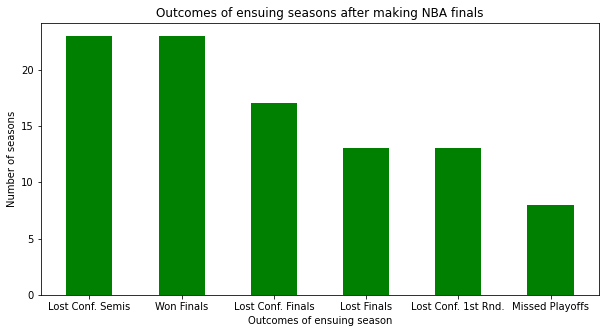

In [44]:
## Question 10: Making finals performance in ensuing year
next_seasons = []
for key in year_stats:
    b = False
    for year in year_stats[key]:
        if int(year[0][:4]) < 1970:
            continue
        if b == True:
            next_seasons.append(year)
            b = False
        if year[4] == 'Won Finals' or year[4] == 'Lost Finals':
            b = True

next_seasons_sorted = sorted(next_seasons, key=lambda x: x[0])

next_seasons_performances = {}
temp = []
for item in next_seasons_sorted:
    performance = item[4]
    if performance == '':
        performance = 'Missed Playoffs'
    if performance == 'Lost W. Div. Finals' or performance == 'Lost E. Div. Finals':
        continue
    if performance == 'Lost E. Div. Semis' or performance == 'Lost W. Div. Semis':
        continue
    if performance == 'Eliminated in E. Div. Rnd. Robin' or performance == 'Lost 1st Rnd.':
        continue
    if performance == 'Lost E. Conf. Finals' or performance == 'Lost W. Conf. Finals':
        performance = 'Lost Conf. Finals'
    if performance == 'Lost E. Conf. Semis' or performance == 'Lost W. Conf. Semis':
        performance = 'Lost Conf. Semis'
    if performance == 'Lost E. Conf. 1st Rnd.' or performance == 'Lost W. Conf. 1st Rnd.':
        performance = 'Lost Conf. 1st Rnd.'
    if performance in temp:
        next_seasons_performances[performance] += 1
    else:
        temp.append(performance)
        next_seasons_performances[performance] = 1


next_seasons_performances = {k: v for k, v in sorted(next_seasons_performances.items(), key=lambda item: item[1], reverse=True)}


fig, ax = plt.subplots(figsize=(10,5))
bar = plt.bar(next_seasons_performances.keys(), next_seasons_performances.values(), width=0.5, color='g')
ax.set_xlabel('Outcomes of ensuing season')
ax.set_ylabel('Number of seasons')
ax.set_title('Outcomes of ensuing seasons after making NBA finals')
fig.show()

/var/folders/yh/0wx5sr8520bcl4c1grkslxww0000gn/T/ipykernel_29487/590566885.py:42: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


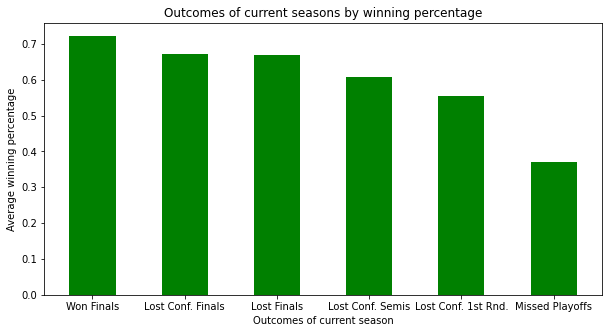

In [45]:
## Question 11: Win/loss percentage effect on same season playoff performance

temp = []
this_seasons_performances = {}
for key in year_stats:
    for year in year_stats[key]:
        if int(year[0][:4]) < 1970:
            continue
        performance = year[4]
        if performance == '':
            performance = 'Missed Playoffs'
        if performance == 'Lost W. Div. Finals' or performance == 'Lost E. Div. Finals' or performance == 'Lost Semis':
            continue
        if performance == 'Lost E. Div. Semis' or performance == 'Lost W. Div. Semis' or performance == 'Lost W. Div. Tiebreaker':
            continue
        if performance == 'Eliminated in E. Div. Rnd. Robin' or performance == 'Lost 1st Rnd.':
            continue
        if performance == 'Lost E. Conf. Finals' or performance == 'Lost W. Conf. Finals':
            performance = 'Lost Conf. Finals'
        if performance == 'Lost E. Conf. Semis' or performance == 'Lost W. Conf. Semis':
            performance = 'Lost Conf. Semis'
        if performance == 'Lost E. Conf. 1st Rnd.' or performance == 'Lost W. Conf. 1st Rnd.':
            performance = 'Lost Conf. 1st Rnd.'
        #print(year[0], year[3], performance)
        if performance in temp:
            this_seasons_performances[performance].append(float(year[3]))
        else:
            temp.append(performance)
            this_seasons_performances[performance] = [float(year[3])]

for key in this_seasons_performances:
    temp = this_seasons_performances[key]
    this_seasons_performances[key] = float(sum(temp)) / float(len(temp))
    
this_seasons_performances2 = {k: v for k, v in sorted(this_seasons_performances.items(), key=lambda item: item[1], reverse=True)}
    
fig, ax = plt.subplots(figsize=(10,5))
bar = plt.bar(this_seasons_performances2.keys(), this_seasons_performances2.values(), width=0.5, color='g')
ax.set_xlabel('Outcomes of current season')
ax.set_ylabel('Average winning percentage')
ax.set_title('Outcomes of current seasons by winning percentage')
fig.show()
            


<ipython-input-78-4180acba1ce4>:46: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


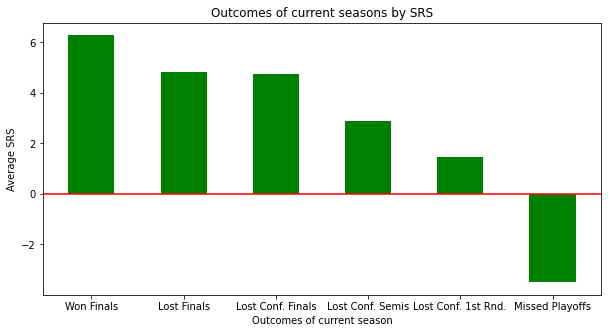

In [78]:
## Question 12: SRS effect on same season playoff performance

## Question 11: Win/loss percentage effect on same season playoff performance
## 70-71 is good

temp = []
this_seasons_performances = {}
for key in year_stats:
    for year in year_stats[key]:
        if int(year[0][:4]) < 1970:
            continue
        performance = year[4]
        if performance == '':
            performance = 'Missed Playoffs'
        if performance == 'Lost W. Div. Finals' or performance == 'Lost E. Div. Finals' or performance == 'Lost Semis':
            continue
        if performance == 'Lost E. Div. Semis' or performance == 'Lost W. Div. Semis' or performance == 'Lost W. Div. Tiebreaker':
            continue
        if performance == 'Eliminated in E. Div. Rnd. Robin' or performance == 'Lost 1st Rnd.':
            continue
        if performance == 'Lost E. Conf. Finals' or performance == 'Lost W. Conf. Finals':
            performance = 'Lost Conf. Finals'
        if performance == 'Lost E. Conf. Semis' or performance == 'Lost W. Conf. Semis':
            performance = 'Lost Conf. Semis'
        if performance == 'Lost E. Conf. 1st Rnd.' or performance == 'Lost W. Conf. 1st Rnd.':
            performance = 'Lost Conf. 1st Rnd.'
        #print(year[0], year[5], performance)
        if performance in temp:
            this_seasons_performances[performance].append(float(year[5]))
        else:
            temp.append(performance)
            this_seasons_performances[performance] = [float(year[5])]

for key in this_seasons_performances:
    temp = this_seasons_performances[key]
    this_seasons_performances[key] = float(sum(temp)) / float(len(temp))
    
this_seasons_performances2 = {k: v for k, v in sorted(this_seasons_performances.items(), key=lambda item: item[1], reverse=True)}
    
fig, ax = plt.subplots(figsize=(10,5))
bar = plt.bar(this_seasons_performances2.keys(), this_seasons_performances2.values(), width=0.5, color='g')
plt.axhline(y=0, color='r', linestyle='-')
ax.set_xlabel('Outcomes of current season')
ax.set_ylabel('Average SRS')
ax.set_title('Outcomes of current seasons by SRS')
fig.show()